In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import scipy as sc
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import sklearn
import glob

## PCA on HRDPS data

In [2]:
files = glob.glob('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2007m??d??.nc')
##list of data files, febrary 2007 - each file covers one day, with hourly data
##the grid is 266 by 256 points, with resolution 2.5km
##relevant data in this file is u_wind and v_wind data
files.sort()
print(len(files))

363


In [3]:
##data must be converted into a 2D matrix for pca analysis
##transform takes a 3D data array (time, a, b) -> (a*b, time)
##(the data grid is flattened a column using numpy.flatten)

def transform(xarr):
    arr = np.array(xarr)
    data3 = np.empty((arr.shape[1]*arr.shape[2], arr.shape[0])) 
    for i in range(arr.shape[0]):
        flattened_arr = arr[i,:,:].flatten(order = 'C')
        data3[:, i] = flattened_arr[:]; 
    return data3

##reverse does the inverse of transform
def reverse(arr, arr_orig):
    a = arr_orig.shape[1]
    b = arr_orig.shape[2]
    data4 = np.empty((arr.shape[1], a, b))
    for i in range(arr.shape[1]):
        temp = arr[:,i].reshape(a,b)
        data4[i,:,:] = temp
    ##arr_new = arr_orig.copy(data = data4) ##copies the metadata from arr_orig, and the data from data4
    return data4

In [4]:
## 3-hour averaged matrix

u_data3 = np.empty( (8*len(files), 266, 256)) 
v_data3 = np.empty( (8*len(files), 266, 256)) 

for i in range(len(files)):
    dayX = xr.open_dataset(files[i])
    for j in range(8):
        u_3 = np.array( dayX['u_wind'][j*3:j*3 + 3, 0:266, 0:256] )
        v_3 = np.array( dayX['v_wind'][j*3:j*3 + 3, 0:266, 0:256] )
        avg_u = u_3.mean(axis = 0) ##average of 3-hour time interval
        avg_v = v_3.mean(axis = 0)
        u_data3[8*i + j, : , : ] = avg_u[0:266, 0:256] ##adding 3-hour average to new data array
        v_data3[8*i + j, : , : ] = avg_v[0:266, 0:256]
    
u_mat3 = transform(u_data3)
v_mat3 = transform(v_data3)
c_mat3 = np.concatenate((u_mat3,v_mat3), axis=0)

In [13]:
u_data3.shape

(2904, 266, 256)

In [5]:
##conducting PCA analysis on combined data matrix
pca = PCA(n_components = 50) ##adjust the number of principle conponents to be calculated
PCs_h = pca.fit_transform(c_mat3)
eigvecs_h = pca.components_
fracVar_h = pca.explained_variance_ratio_

##reconstructing data using the chosen number of principle conponents
new_mat = pca.inverse_transform(pca.transform(c_mat3))
new_u = reverse(new_mat[:266*256,:], u_data3) ##reconstructing u_winds from 10 PCs
new_v = reverse(new_mat[266*256:,:], v_data3) ##reconstructing v_winds from 10 PCs

In [12]:
##graphing percentage of original data represented by the first n principle conponents
def graph_variance(matrix, n):
    pcaG = PCA(n_components = n) ##Number of principle conponents to show
    PCsG = pcaG.fit_transform(matrix)
    plt.plot(np.cumsum(pcaG.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show()

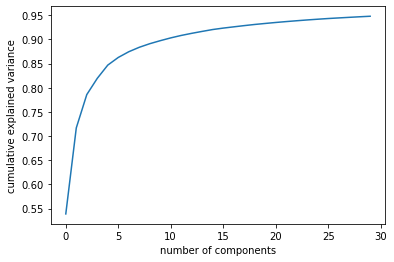

In [7]:
graph_variance(c_mat3, 30)

In [13]:
def get_mode(PCs, n, arr_orig): ##converts PCs (column vectors) to 2d conpoents for u and v wind
    split = int(PCs.shape[0]/2)
    mode_u = PCs[:split, n].reshape(arr_orig.shape[1], arr_orig.shape[2])
    mode_v = PCs[split:, n].reshape(arr_orig.shape[1], arr_orig.shape[2])
    return (mode_u, mode_v)

def graph_nPCs(PCs, eigvecs, n, arr_orig):
    fig, ax = plt.subplots(n, 3, figsize=(10, 3*n))
    
    ax[0, 0].set_title("u-conponent")
    ax[0, 1].set_title("v-component")
    ax[0, 2].set_title("time-loadings")
    
    for i in range(n):
        mode_u, mode_v = get_mode(PCs, i, arr_orig)
        colors = ax[i, 0].pcolormesh(mode_u, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,0])
        colors = ax[i, 1].pcolormesh(mode_v, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,1])
        ax[i, 2].plot(eigvecs[i])

    plt.tight_layout()
    plt.show()

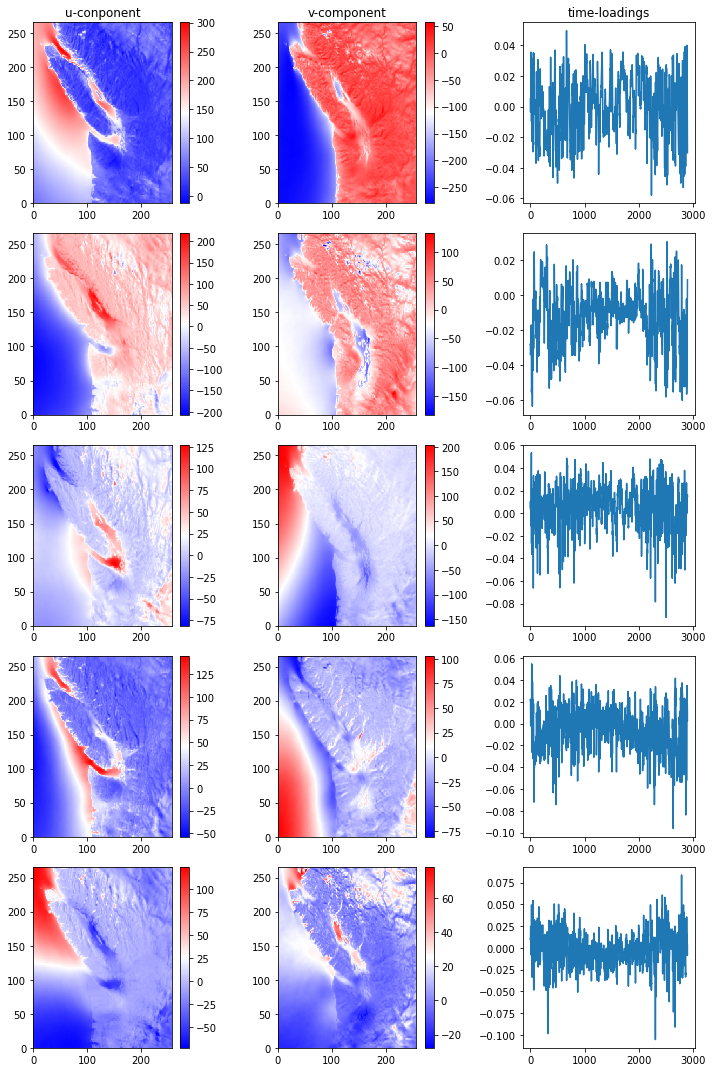

In [12]:
graph_nPCs(PCs_h, eigvecs_h, 5, u_data3)

## Pressure PCA on CANRCM data

In [8]:
p3 = '/home/arandhawa/canrcm_sea_level_pressure_2007.nc'
d3 = xr.open_dataset(p3)
print(d3)

<xarray.Dataset>
Dimensions:       (time: 2920, rlon: 310, rlat: 260)
Coordinates:
  * time          (time) object 2007-01-01 00:00:00 ... 2007-12-31 21:00:00
  * rlon          (rlon) float64 -33.99 -33.77 -33.55 ... 33.55 33.77 33.99
  * rlat          (rlat) float64 -28.71 -28.49 -28.27 ... 27.83 28.05 28.27
    lon           (rlat, rlon) float64 ...
    lat           (rlat, rlon) float64 ...
Data variables:
    rotated_pole  |S1 ...
    psl           (time, rlat, rlon) float32 ...
Attributes: (12/23)
    title:                          CanRCM4 model output prepared for CORDEX ...
    institution:                    CCCma (Canadian Centre for Climate Modell...
    institute_id:                   CCCma
    contact:                        cccma_info@ec.gc.ca
    Conventions:                    CF-1.4
    experiment:                     Evaluation run with ERA-INTERIM reanalysi...
    ...                             ...
    frequency:                      3hr
    product:                

In [37]:
pressure = np.array(d3['psl'][16:,140:165,60:85])
pres_mat = transform(pressure)

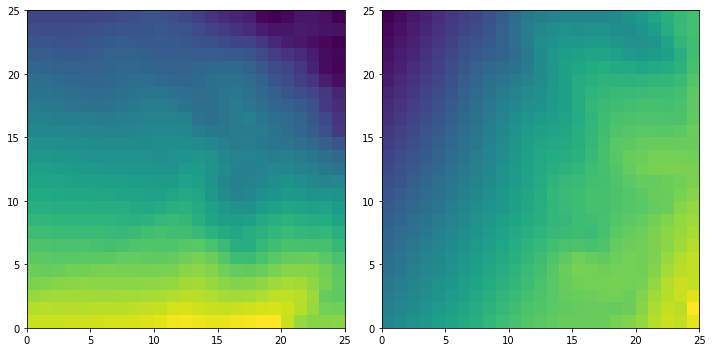

In [38]:
#plots of original data at two timestamps
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pcolormesh(pressure[0,:,:])
axs[1].pcolormesh(pressure[500,:,:])
fig.tight_layout()

In [39]:
##conducting PCA analysis on combined data matrix
pca = PCA(n_components = 50) ##adjust the number of principle conponents to be calculated
PCs = pca.fit_transform(pres_mat)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

In [40]:
def graph_pressure(PCs, eigvecs, n, arr_orig):
    fig, ax = plt.subplots(n, 2, figsize=(7, 3*n))
    
    ax[0, 0].set_title("Modes")
    ax[0, 1].set_title("Time-loadings")
    
    for i in range(n):
        mode = PCs[:,i].reshape(arr_orig.shape[1], arr_orig.shape[2])
        colors = ax[i, 0].pcolormesh(mode, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,0])
    
        ax[i, 1].plot(eigvecs[i])

    plt.tight_layout()
    plt.show()

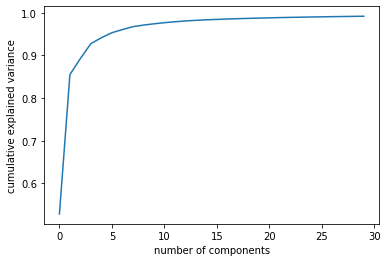

In [41]:
graph_variance(pres_mat, 30)

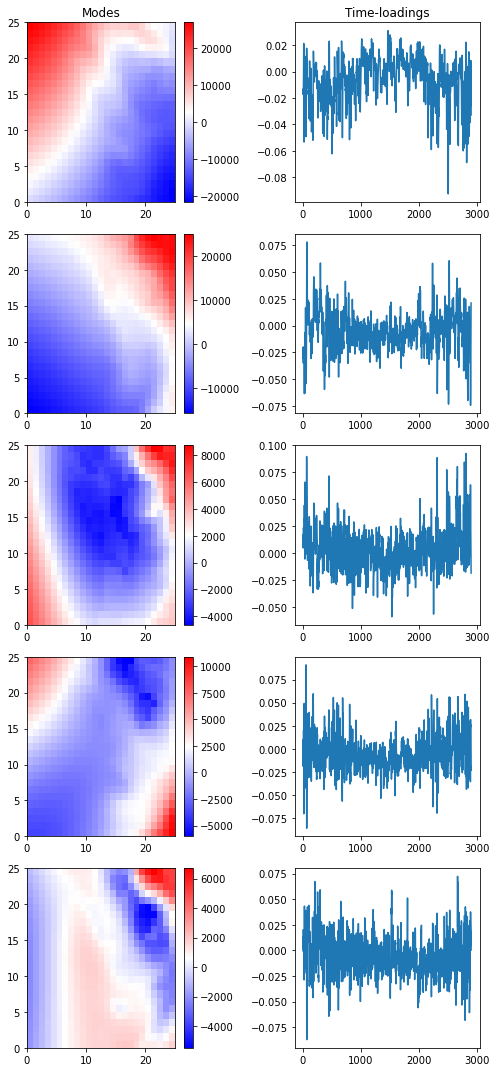

In [42]:
graph_pressure(PCs, eigvecs, 5, pressure)

In [44]:
d3.close()

## CANRCM Winds

In [50]:
p1 = '/home/arandhawa/canrcm_2007_uas.nc'
p2 = '/home/arandhawa/canrcm_2007_vas.nc'

d1 = xr.open_dataset(p1)
d2 = xr.open_dataset(p2)

A2 = d1['uas'][16:,140:165,60:85]
B2 = d2['vas'][16:,140:165,60:85]

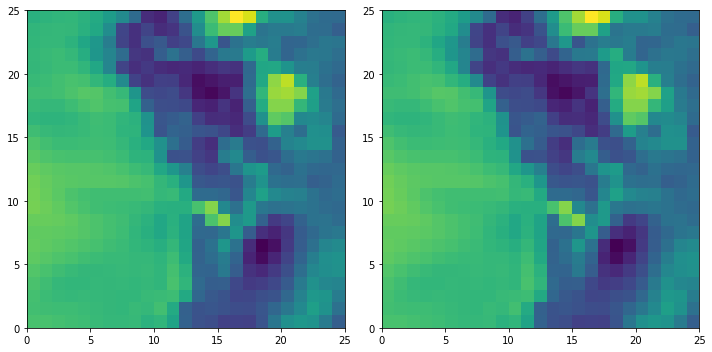

In [51]:
#plots of original data at two timestamps
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pcolormesh(np.array(A2)[0,:,:])
axs[1].pcolormesh(np.array(A2)[0,:,:])
fig.tight_layout()

In [52]:
A_mat2 = transform(A2)
B_mat2 = transform(B2)
C_mat2 = np.concatenate((A_mat2,B_mat2), axis=0) 

##conducting PCA analysis on combined data matrix
pca2 = PCA(n_components = 30) ##adjust the number of principle conponents to be calculated
PCs2 = pca2.fit_transform(C_mat2)
eigvecs2 = pca2.components_
fracVar2 = pca2.explained_variance_ratio_

##reconstructing data using the chosen number of principle conponents
C_new2 = pca2.inverse_transform(pca2.transform(C_mat2))
split2 = int( C_new2.shape[0]/2 )
A_new2 = reverse(C_new2[:split2,:], A2) ##reconstructing u_winds from 10 PCs
B_new2 = reverse(C_new2[split2:,:], B2) ##reconstructing v_winds from 10 PCs

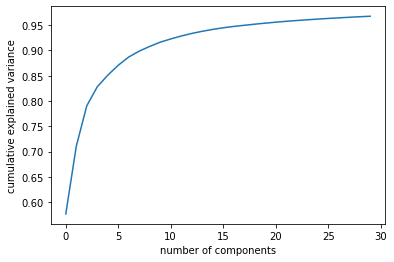

In [53]:
##graphing percentage of original data represented by the first n principle conponents
graph_variance(C_mat2, 30)

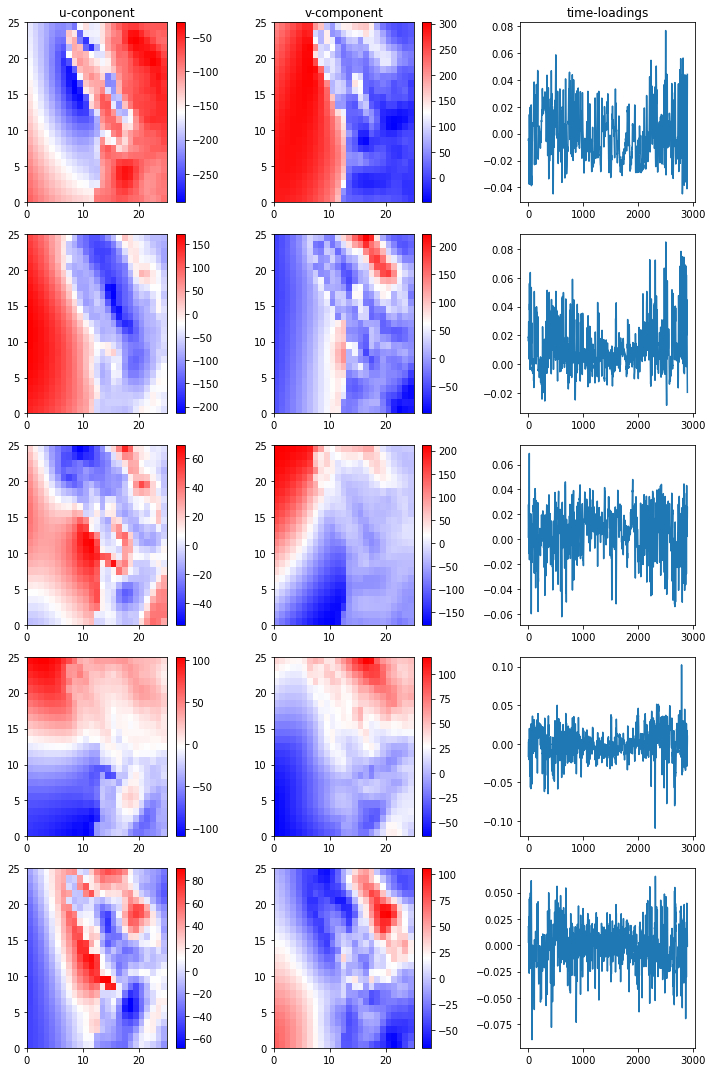

In [54]:
graph_nPCs(PCs2, eigvecs2, 5, A2)

## Exports

In [11]:
np.savetxt("eigvecs_hrdps_annual.csv", eigvecs_h, delimiter=",") ##HRDPS exports
np.savetxt("PCs_hrdps_annual.csv", PCs_h, delimiter=",")
np.savetxt("raw_data_3h.csv", c_mat3, delimiter=",")

In [43]:
np.savetxt("eigvecs_psl.csv", eigvecs, delimiter=",") ##CANRCM pressure exports
np.savetxt("PCs_psl.csv", PCs, delimiter=",")
np.savetxt("raw_data_psl.csv", pres_mat, delimiter=",")

In [55]:
np.savetxt("eigvecs_winds.csv", eigvecs2, delimiter=",") ##CANRCM wind exports
np.savetxt("PCs_winds.csv", PCs2, delimiter=",")
np.savetxt("raw_data_winds.csv", C_mat2, delimiter=",")